In [1]:
import sys

sys.path
sys.executable

'/Users/nandinisahu/opt/anaconda3/envs/lenstro_pip/bin/python'

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
import lenstronomy.Util.util as util
import lenstronomy.Util.image_util as image_util
from lenstronomy.Util import param_util
from lenstronomy.Util import mask_util
from lenstronomy.Util.util import array2image
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Sampling.parameters import Param
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
import numpy as np
import os
import pickle
import copy
import time
import h5py
from pprint import pprint
import joblib
from astropy.cosmology import FlatLambdaCDM
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.Plots import  plot_util

cwd = os.getcwd()
base_path = cwd
print('Base directory path:', base_path)

Base directory path: /Users/nandinisahu/Library/CloudStorage/OneDrive-UNSW/AGEL/compound_lens/compound_lens_dcls1507-NS-main/notebooks


In [3]:
import lenstronomy
lenstronomy.__version__

'1.12.3'

In [4]:
import matplotlib as mpl

# for MNRAS
mpl.rcParams['ps.fonttype'] = 42

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid, make_axes_locatable
import matplotlib.image as mpimg
import seaborn as sns
import sys
sys.path.append('/Users/nandinisahu/Library/CloudStorage/OneDrive-UNSW/AGEL/compound_lens/coloripy')
import coloripy as cp

# to change tex to Times New Roman in mpl
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['mathtext.it'] = 'serif:italic'
plt.rcParams['mathtext.bf'] = 'serif:bold'
plt.rcParams['mathtext.fontset'] = 'custom'


sns.set(style='ticks', context='paper', font='Times New Roman', font_scale=2.)
#sns.set_context('talk')
sns.set_style({"xtick.direction": "in","ytick.direction": "in", "axes.linewidth": 2.0,})
#sns.set_palette('Set2')

cmap = sns.cubehelix_palette(start=0.5, rot=-1.5, gamma=1, hue=1, light=-.6, dark=0.8, reverse=False, as_cmap=True)
cmap2 = sns.cubehelix_palette(start=0.5, rot=-1.5, gamma=1, hue=1, light=-.2, dark=1., reverse=False, as_cmap=True)

msh_cmap = cp.get_msh_cmap(num_bins=501, rescale='power', power=2.5)

In [5]:
import h5py

def import_data(filter_name):
    
    data_file = os.path.join('../data/image_DCLS1507+0522_{}.h5'.format(filter_name))
    f = h5py.File(data_file, 'r')
    
    kwargs_data = {}
    for key in f:
        kwargs_data[key] = f[key][()]
    f.close()

    # get data and PSF estimate from file
    psf_file = os.path.join('../PSF files/psf_model_{}.h5'.format(filter_name))
    f = h5py.File(psf_file, 'r')
    kernel_point_source = f['kernel_point_source'][()]
    # psf_error_map = f['psf_error_map'][()]
    f.close()


    kwargs_psf = {'psf_type': "PIXEL", 
                'kernel_point_source': kernel_point_source ,
                'kernel_point_source_init': kernel_point_source ,
                #    'psf_error_map': psf_error_map,
                }

    return kwargs_data, kwargs_psf

kwargs_data_F200LP, kwargs_psf_F200LP = import_data('F200LP')
kwargs_data_F140W, kwargs_psf_F140W = import_data('F140W')

kwargs_data_F140W['ra_shift'] = kwargs_data_F140W['ra_shift'] - kwargs_data_F200LP['ra_shift']
kwargs_data_F140W['dec_shift'] = kwargs_data_F140W['dec_shift'] - kwargs_data_F200LP['dec_shift']

kwargs_data_F200LP['ra_shift'] = 0
kwargs_data_F200LP['dec_shift'] = 0

In [6]:
kwargs_data_F140W

{'background_rms': 0.02259360440075,
 'dec_at_xy_0': -7.034488715086257,
 'dec_shift': 0.012699999999999934,
 'exposure_time': array([[219.1675 , 208.12521, 217.50636, ..., 202.67644, 227.30098,
         240.72963],
        [268.05038, 216.44777, 281.9542 , ..., 223.26054, 223.02518,
         235.99332],
        [251.9576 , 203.57751, 280.07587, ..., 215.60355, 254.16888,
         269.4963 ],
        ...,
        [239.1487 , 266.9713 , 209.9095 , ..., 202.46257,  95.80747,
         219.91754],
        [216.88469, 246.2649 , 183.09084, ..., 192.94171,  98.44137,
         221.15611],
        [222.99677, 243.6608 , 192.39893, ..., 183.53331,  91.49941,
         206.21883]], dtype='>f4'),
 'image_data': array([[ 2.2908628e-02,  2.1038681e-02, -5.4276586e-03, ...,
         -1.0041654e-02, -9.0478063e-03, -2.0102471e-02],
        [ 2.6980639e-03,  4.8935413e-05, -3.0648381e-02, ...,
          2.7212024e-02, -4.2562425e-02, -5.7859570e-02],
        [ 2.7310282e-02,  1.3994843e-02, -4.0135384e

Pixel size: 0.05 arcsec
numPix: 240
********************
Lens center: -0.8395023773705237 -0.48224204139963334
********************
Galaxy 1 center: -0.40495199683448746 1.152141851292571
Galaxy 2 center: -0.7259344298101684 -1.9257777388153974
********************
Source 1 center: -0.9946517084153268 1.141853220018103
********************
Image S1 center 0: -0.7259344298101684, -1.9257777388153974
Image S1 center 1: 1.077677899407675, 4.24811644599183
Image S1 center 2: -1.3107344591144519, 4.338782346204262
Image S1 center 3: -3.6282050419045113, 3.5019453591584284
********************
********************
Source 2 center: 0.6167336450339843 -0.20958171313143767
********************
Image S2 center 0: 4.684474513668903, 0.5062295049084398
Image S2 center 1: -2.0350943517481808, -2.422953578967986
Image S2 center 2: -3.488116480968383, -0.9227397283898604
Image S2 center 3: -2.239525403868929, 1.1434651690498185
********************


/var/folders/v5/068qyr6n1v16l5m5qs3sthxm0000gn/T/ipykernel_39003/1315279739.py:22: RuntimeWarning: invalid value encountered in log10
  ax.matshow(np.log10(data_cutout), origin='lower', cmap=cmap, vmin=-6, vmax=1.0) #v_min=-3,v_max= -0.2


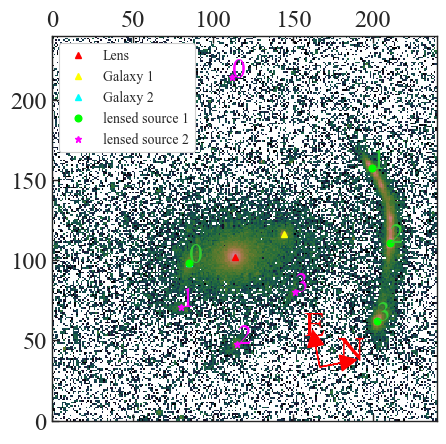

In [8]:
# %matplotlib ipympl
%matplotlib inline

# read-in the coordiante system of the exposure
ra_at_xy_0 = kwargs_data_F200LP['ra_at_xy_0']
dec_at_xy_0 = kwargs_data_F200LP['dec_at_xy_0']
transform_pix2angle = kwargs_data_F200LP['transform_pix2angle']
coords_F200LP = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)


# read-in the reduced cutout image
data_cutout = kwargs_data_F200LP['image_data']
numPix = len(data_cutout)
deltaPix = coords_F200LP.pixel_width
print('Pixel size: {:.2f} arcsec'.format(deltaPix))
print('numPix:', numPix)
# print('transform_pix2angle:', transform_pix2angle)

print('*'*20)

ax = plt.figure(figsize=(5, 5)).add_subplot(111)
ax.matshow(np.log10(data_cutout), origin='lower', cmap=cmap, vmin=-6, vmax=1.0) #v_min=-3,v_max= -0.2
ax.autoscale(False)

kwargs_pixel = {'nx': numPix, 'ny': numPix,  # number of pixels per axis
                'ra_at_xy_0': ra_at_xy_0,  # RA at pixel (0,0)
                'dec_at_xy_0': dec_at_xy_0,  # DEC at pixel (0,0)
                'transform_pix2angle': transform_pix2angle} 

pixel_grid = PixelGrid(**kwargs_pixel)
plot_util.coordinate_arrows(ax, d=200, coords=pixel_grid, color='red', font_size=25, arrow_size=0.05)

lens_x_F200LP, lens_y_F200LP =113.73636, 101.67792  #113, 102   114.66136, 102.96184
lens_ra_F200LP, lens_dec_F200LP = coords_F200LP.map_pix2coord(lens_x_F200LP, lens_y_F200LP)
ax.plot(lens_x_F200LP, lens_y_F200LP, '^', color='red', label='Lens') 
print('Lens center:', lens_ra_F200LP, lens_dec_F200LP) 

print('*'*20)

gal1_x_F200LP, gal1_y_F200LP =144.16586, 116.44726 #144, 116   145.16586, 116.94726
gal1_ra_F200LP, gal1_dec_F200LP = coords_F200LP.map_pix2coord(gal1_x_F200LP, gal1_y_F200LP)
ax.plot(gal1_x_F200LP, gal1_y_F200LP, '^', color='yellow', label='Galaxy 1') 
print('Galaxy 1 center:', gal1_ra_F200LP, gal1_dec_F200LP)

gal2_x_F200LP, gal2_y_F200LP =84.9617, 98.3979 #144, 116   145.16586, 116.94726
gal2_ra_F200LP, gal2_dec_F200LP = coords_F200LP.map_pix2coord(gal2_x_F200LP, gal2_y_F200LP )
ax.plot(gal2_x_F200LP, gal2_y_F200LP, '^', color='cyan', label='Galaxy 2') 
print('Galaxy 2 center:', gal2_ra_F200LP, gal2_dec_F200LP)

print('*'*20)
#s1_x_img_pos,s1_y_img_pos =159.49841980975322, 86.19625327873504 # not final
#s1_x, s1_y =coords.map_pix2coord(s1_x_img_pos,s1_y_img_pos)
s1_x, s1_y=-0.9946517084153268, 1.141853220018103
s1_x_img_pos,s1_y_img_pos = coords_F200LP.map_coord2pix(s1_x, s1_y )
#ax.plot(s1_x_img_pos, s1_y_img_pos, '^', color='lime',markersize=10, label='Source 1')
print('Source 1 center:', s1_x, s1_y)
print('*'*20)

# estimate point source positions in pixel
im_pos_x = np.array([ 84.9617, 199.2906, 210.1870, 202.6028]) #84.9617,
im_pos_y = np.array([ 98.3979,157.3715, 110.8272, 62.1356]) #98.3979,

ra_image, dec_image = coords_F200LP.map_pix2coord(im_pos_x, im_pos_y)
ax.plot(im_pos_x, im_pos_y, 'o', color='lime',label='lensed source 1')

ra_image_1, dec_image_1 = copy.deepcopy(ra_image), copy.deepcopy(dec_image)

for i in range(len(im_pos_x)):
    ax.text(im_pos_x[i], im_pos_y[i], i, fontsize=20, color='limegreen')
    print('Image S1 center {}: {}, {}'.format(i, ra_image[i], dec_image[i]))

print('*'*20)
print('*'*20)

#s2_x_img_pos,s2_y_img_pos = 113.8880243857698, 129.71950917762942 # not final
#s2_x, s2_y =coords.map_pix2coord(s2_x_img_pos,s2_y_img_pos)
s2_x, s2_y= 0.6167336450339843, -0.20958171313143767
s2_x_img_pos,s2_y_img_pos = coords_F200LP.map_coord2pix( s2_x, s2_y)
#ax.plot(s2_x_img_pos,s2_y_img_pos, '^', color='magenta', label='Source 2',markersize=10)
print('Source 2 center:', s2_x, s2_y)
print('*'*20)

im_pos_x_s2=([112.0587, 80.1975, 115.1975, 150.9979 ])
im_pos_y_s2=([213.8998, 70.7983, 47.9979, 80.3970 ])

ra_image_s2, dec_image_s2 = coords_F200LP.map_pix2coord(im_pos_x_s2, im_pos_y_s2)
ax.plot(im_pos_x_s2, im_pos_y_s2, '*', color='magenta',label='lensed source 2')

ra_image_2, dec_image_2 = copy.deepcopy(ra_image_s2), copy.deepcopy(dec_image_s2)

for i in range(len(ra_image_2)):
    ax.text(im_pos_x_s2[i], im_pos_y_s2[i], i, fontsize=20, color='magenta')
    print('Image S2 center {}: {}, {}'.format(i, ra_image_s2[i], dec_image_s2[i]))

print('*'*20)

#print(coords.map_pix2coord(115.198,  47.998))

plt.legend(loc='upper left', fontsize=10, framealpha=1)
#plt.savefig(fname='DSPL1507.pdf', format='pdf')
plt.show()

Pixel size: 0.08 arcsec
numPix: 150
********************
********************
Lens center: -0.8294023773705237 -0.4695420413996334
Gal1 center: -0.39485199683448746 1.164841851292571
Gal2 center: -0.72 -1.91
********************
Source 1 center: -0.9946517084153268 1.141853220018103
********************
Image S1 center 0: -0.7158344298101684, -1.9130777388153974
Image S1 center 1: 1.087777899407675, 4.260816445991829
Image S1 center 2: -1.3006344591144519, 4.3514823462042616
Image S1 center 3: -3.6181050419045113, 3.514645359158428
pixel coordinates: [ 53.2326691  124.68862561 131.49864463 126.75826298], [61.653094   98.51099973 69.42075798 38.98854946] 

********************
Image S2 center 0: 4.694574513668902, 0.5189295049084397
Image S2 center 1: -2.0249943517481808, -2.4102535789679864
Image S2 center 2: -3.478016480968383, -0.9100397283898605
Image S2 center 3: -2.229425403868929, 1.1561651690498185
pixel coordinates: [70.16891011 50.25489826 72.12980857 94.50525367], [133.841635

/var/folders/v5/068qyr6n1v16l5m5qs3sthxm0000gn/T/ipykernel_39003/1481115202.py:20: RuntimeWarning: invalid value encountered in log10
  ax.matshow(np.log10(data_cutout), origin='lower', cmap=cmap, vmin=-2, vmax=0.2) #v_min=-3,v_max= -0.2


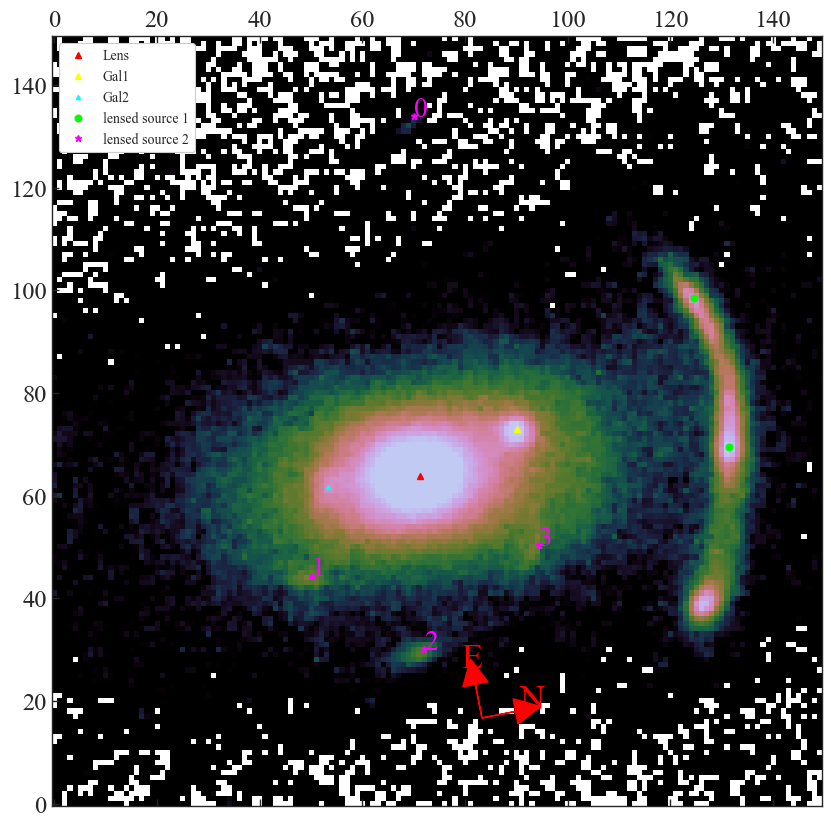

In [9]:
# %matplotlib ipympl
%matplotlib inline

# read-in the coordiante system of the exposure
ra_at_xy_0 = kwargs_data_F140W['ra_at_xy_0']
dec_at_xy_0 = kwargs_data_F140W['dec_at_xy_0']
transform_pix2angle = kwargs_data_F140W['transform_pix2angle']
coords_F140W = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)

# read-in the reduced cutout image
data_cutout = kwargs_data_F140W['image_data']
numPix = len(data_cutout)
deltaPix = coords_F140W.pixel_width
print('Pixel size: {:.2f} arcsec'.format(deltaPix))
print('numPix:', numPix)
# print('transform_pix2angle:', transform_pix2angle)
print('*'*20)

ax = plt.figure(figsize=(10, 10)).add_subplot(111)
ax.matshow(np.log10(data_cutout), origin='lower', cmap=cmap, vmin=-2, vmax=0.2) #v_min=-3,v_max= -0.2
ax.autoscale(False)

kwargs_pixel = {'nx': numPix, 'ny': numPix,  # number of pixels per axis
                'ra_at_xy_0': ra_at_xy_0,  # RA at pixel (0,0)
                'dec_at_xy_0': dec_at_xy_0,  # DEC at pixel (0,0)
                'transform_pix2angle': transform_pix2angle} 

pixel_grid = PixelGrid(**kwargs_pixel)
plot_util.coordinate_arrows(ax, d=100, coords=pixel_grid, color='red', font_size=25, arrow_size=0.05)

print('*'*20)
lens_ra_F140W, lens_dec_F140W=lens_ra_F200LP+kwargs_data_F140W['ra_shift'], lens_dec_F200LP+kwargs_data_F140W['dec_shift']
lens_x_F140W,lens_y_F140W=coords_F140W.map_coord2pix(lens_ra_F140W, lens_dec_F140W)
ax.plot(lens_x_F140W,lens_y_F140W, '^', color='red', label='Lens') 
print('Lens center:', lens_ra_F140W, lens_dec_F140W) 

gal1_ra_F140W, gal1_dec_F140W=gal1_ra_F200LP+kwargs_data_F140W['ra_shift'], gal1_dec_F200LP+kwargs_data_F140W['dec_shift']
gal1_x_F140W,gal1_y_F140W=coords_F140W.map_coord2pix(gal1_ra_F140W, gal1_dec_F140W)
ax.plot(gal1_x_F140W,gal1_y_F140W, '^', color='yellow', label='Gal1') 
print('Gal1 center:', gal1_ra_F140W, gal1_dec_F140W) 

gal2_ra_F140W, gal2_dec_F140W=-0.72, -1.91
#gal2_ra_F200LP+kwargs_data_F140W['ra_shift'], gal2_dec_F200LP+kwargs_data_F140W['dec_shift']
gal2_x_F140W,gal2_y_F140W=coords_F140W.map_coord2pix(gal2_ra_F140W, gal2_dec_F140W)
ax.plot(gal2_x_F140W,gal2_y_F140W, '^',markersize=3, color='cyan', label='Gal2') 
print('Gal2 center:', gal2_ra_F140W, gal2_dec_F140W) 

print('*'*20)

s1_x, s1_y=-0.9946517084153268, 1.141853220018103
s1_x_img_pos,s1_y_img_pos = coords_F200LP.map_coord2pix(s1_x, s1_y )
#ax.plot(s1_x_img_pos, s1_y_img_pos, '^', color='lime',markersize=10, label='Source 1')
print('Source 1 center:', s1_x, s1_y)


print('*'*20)


im_pos_ra_F140W, im_pos_dec_F140W=ra_image+kwargs_data_F140W['ra_shift'], dec_image+kwargs_data_F140W['dec_shift']
im_pos_x_F140W, im_pos_y_F140W=coords_F140W.map_coord2pix(im_pos_ra_F140W, im_pos_dec_F140W)
ax.plot(im_pos_x_F140W[1:3], im_pos_y_F140W[1:3], 'o', color='lime',label='lensed source 1') #markersize=2,
for i in range(len(im_pos_x_F140W)):
    #ax.text(im_pos_x_F140W[i], im_pos_y_F140W[i], i, fontsize=20, color='limegreen')
    print('Image S1 center {}: {}, {}'.format(i, im_pos_ra_F140W[i], im_pos_dec_F140W[i]))

print('pixel coordinates: {}, {} \n'.format(im_pos_x_F140W, im_pos_y_F140W ))

print('*'*20)


im2_pos_ra_F140W, im2_pos_dec_F140W=ra_image_s2+kwargs_data_F140W['ra_shift'], dec_image_s2+kwargs_data_F140W['dec_shift']
im2_pos_x_F140W, im2_pos_y_F140W=coords_F140W.map_coord2pix(im2_pos_ra_F140W, im2_pos_dec_F140W)
ax.plot(im2_pos_x_F140W, im2_pos_y_F140W, '*', color='magenta',label='lensed source 2')

for i in range(len(im2_pos_ra_F140W)):
    ax.text(im2_pos_x_F140W[i], im2_pos_y_F140W[i], i, fontsize=20, color='magenta')
    print('Image S2 center {}: {}, {}'.format(i, im2_pos_ra_F140W[i], im2_pos_dec_F140W[i]))

print('pixel coordinates: {}, {} \n'.format(im2_pos_x_F140W, im2_pos_y_F140W))

print('*'*20)

plt.legend(loc='upper left', fontsize=10, framealpha=1)
#plt.savefig(fname='DSPL1507.pdf', format='pdf')
plt.show()

Pixel size: 0.08 arcsec


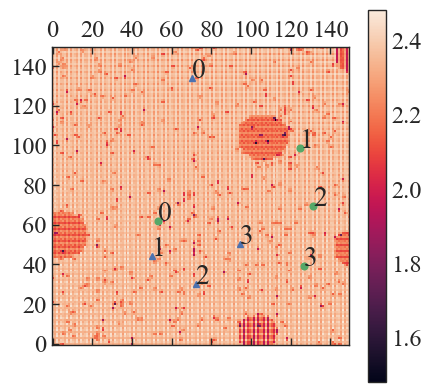

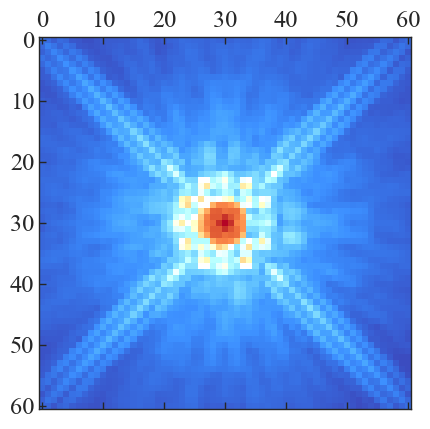

In [10]:
#plot exposure map and PSF
%matplotlib inline 

#coords=coords_F200LP
#coords=coords_F140W

deltaPix = coords_F140W.pixel_width
print('Pixel size: {:.2f} arcsec'.format(deltaPix))
x_coords, y_coords = coords_F140W.coordinate_grid(numPix, numPix)
#wht_map = kwargs_data_F140W['exposure_time']
wht_map = kwargs_data_F140W['exposure_time']

plt.matshow(np.log10(wht_map), origin='lower')
plt.autoscale(False)

plt.plot(im_pos_x_F140W, im_pos_y_F140W,'og')
plt.plot(im2_pos_x_F140W, im2_pos_y_F140W,'^b')

for i in range(len(im_pos_x)):
    plt.text(im_pos_x_F140W[i], im_pos_y_F140W[i], i, fontsize=20)
    plt.text(im2_pos_x_F140W[i], im2_pos_y_F140W[i], i, fontsize=20)
plt.colorbar()
plt.show()


#psf_kernel = kwargs_psf_F140W['kernel_point_source']
psf_kernel = kwargs_psf_F140W['kernel_point_source']
plt.matshow(np.log10(psf_kernel), vmin=-6, cmap=msh_cmap)
plt.show()

/var/folders/v5/068qyr6n1v16l5m5qs3sthxm0000gn/T/ipykernel_39003/371733419.py:55: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(image*mask), origin='lower', cmap=cmap, vmax=1, vmin=-3.5)
/var/folders/v5/068qyr6n1v16l5m5qs3sthxm0000gn/T/ipykernel_39003/371733419.py:55: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(image*mask), origin='lower', cmap=cmap, vmax=1, vmin=-3.5)
/var/folders/v5/068qyr6n1v16l5m5qs3sthxm0000gn/T/ipykernel_39003/371733419.py:63: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(image), origin='lower', cmap=cmap, vmax=1, vmin=-3.5)


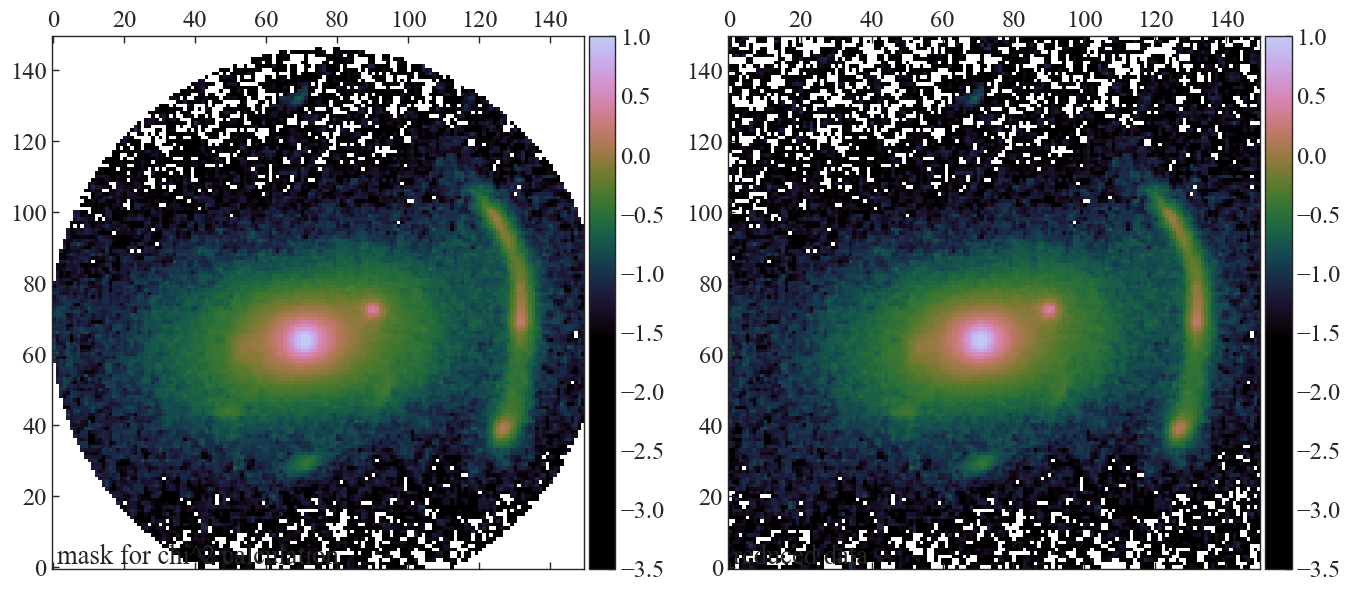

In [11]:
central_mask = True
central_mask_r =0 #0.24 #0.24

#radius of circular aperture to consider 
r_mask_list = [[6.2]
              ]

mask_list = []
index_mask_list = []

for i in range(len(r_mask_list[0])):
    mask_bands = []
    index_mask_bands = []

    for j, kwargs_data in enumerate([kwargs_data_F140W]):
        ra_at_xy_0 = kwargs_data['ra_at_xy_0']
        dec_at_xy_0 = kwargs_data['dec_at_xy_0']
        transform_pix2angle = kwargs_data['transform_pix2angle']
        coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)
        num_pix = len(kwargs_data['image_data'])
        lens_center_ra = lens_ra_F140W
        lens_center_dec = lens_dec_F140W

        x_coords, y_coords = coords.coordinate_grid(num_pix, num_pix)
        r = r_mask_list[j][i]
        mask_outer = mask_util.mask_center_2d(lens_center_ra+0.3, lens_center_dec+0.5, r, util.image2array(x_coords), util.image2array(y_coords))
        index_mask = 1 - mask_util.mask_center_2d(lens_center_ra, lens_center_dec, r, util.image2array(x_coords), util.image2array(y_coords))
        corona = mask_util.mask_center_2d(lens_center_ra, lens_center_dec, central_mask_r, util.image2array(x_coords), util.image2array(y_coords))
 
        mask = (1 - mask_outer) # now modeling both sources

        if central_mask:
            mask *= corona
        
        # mask = 1 - mask_outer

        mask[mask >= 1] = 1
        mask[mask < 0] = 0
        
        mask_bands.append(array2image(mask))
        index_mask_bands.append(index_mask)
        
    mask_list.append(mask_bands)
    index_mask_list.append(index_mask_bands)
    
for j, kwargs_data in enumerate([kwargs_data_F140W]):
    image = kwargs_data['image_data']
    
    f, axes = plt.subplots(1, len(r_mask_list[0])+1, figsize=(16, 8), sharex=False, sharey=False)
    for i in range(len(r_mask_list[0])):
        ax = axes[i]
        
        mask = mask_list[0][j]
        
        im = ax.matshow(np.log10(image*mask), origin='lower', cmap=cmap, vmax=1, vmin=-3.5)
        ax.text(1, 1, 'mask for chi^2 calculation')
        ax.autoscale(False)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

        ax = axes[i+1]
        im = ax.matshow(np.log10(image), origin='lower', cmap=cmap, vmax=1, vmin=-3.5)
        ax.text(1, 1, 'reduced data')
        ax.autoscale(False)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

        plt.show()

/var/folders/v5/068qyr6n1v16l5m5qs3sthxm0000gn/T/ipykernel_39003/1866632064.py:24: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(image*mask), origin='lower')


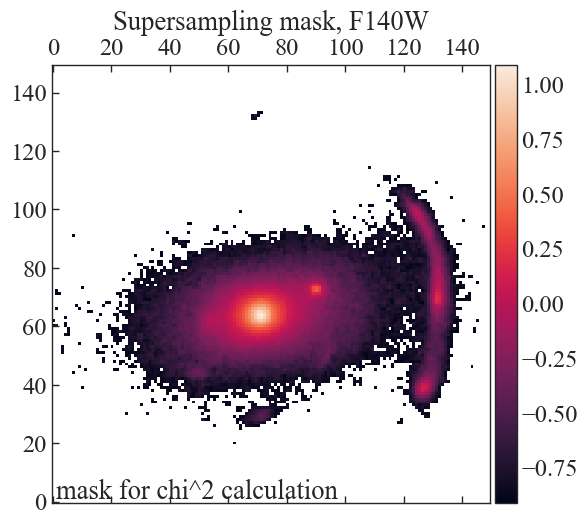

In [12]:
threshold = 10**(5/2.5) 
# pixels with flux > max_flux/threshold will not be supersampled
# here the threshold accepts pixels within 5 magnitude from the pixel with max_flux

supersampling_mask = []

for j, kwargs_data in enumerate([kwargs_data_F140W]):
    s_mask = np.ones_like(kwargs_data['image_data'])
    
    max_flux = np.max(kwargs_data['image_data'])
    s_mask[kwargs_data['image_data'] < max_flux/threshold] = 0
    
    supersampling_mask.append(s_mask)

filters = ['F140W']

for j, kwargs_data in enumerate([kwargs_data_F140W]):
    image = kwargs_data['image_data']
    
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)

    mask = supersampling_mask[j]*mask_list[0][j]
    im = ax.matshow(np.log10(image*mask), origin='lower')
    ax.text(1, 1, 'mask for chi^2 calculation')
    ax.autoscale(False)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ax.set_title("Supersampling mask, "+filters[j])
    plt.colorbar(im, cax=cax)

    plt.show()

In [13]:
from astropy.cosmology import FlatLambdaCDM, wCDM
import astropy.units as u

cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3, Ob0=0.05)

#z_lens = 0.594
# Dominique and Lise claim 2.27 for the qso and 2.35 for the other blob.
#z_source_1 = 2.164
#z_source_2 = 2.6

z_l = 0.594
z_s1 = 2.163
z_s2 = 2.591

D_s1 = cosmo.angular_diameter_distance(z_s1).value
D_s2 = cosmo.angular_diameter_distance(z_s2).value
D_ls1 = cosmo.angular_diameter_distance_z1z2(z_l, z_s1).value
D_ls2 = cosmo.angular_diameter_distance_z1z2(z_l, z_s2).value

#cosmological scaling factor=deflection_scaling= 1/β
deflection_scaling = D_s1 / D_ls1 * D_ls2 / D_s2  
beta=1/deflection_scaling
print('Deflection angle rescale factor: {:.6f}'.format(deflection_scaling))
print('Beta:{:.6f}'.format(beta))

Deflection angle rescale factor: 1.060133
Beta:0.943278


In [14]:
from numpy import True_


ssh_command = 'nsahu@mpa'
dir_path = os.getcwd()
dir_path_cluster = '/afs/mpa/temp/nsahu/dcls1507'


# numeric settings
band_number = 1 # 3

n_p_short = 100 # number of particles in the PSO (for tests)
n_i_short = 100 # number of iterations of the PSO (for tests)
n_p_medium = 48
n_i_medium = 100
n_p_long = 248  # number of particles in the PSO
n_i_long = 250  # number of iterations of the PSO

mcmc_n_burn = 1
mcmc_repeat = 2
mcmc_n_run = 2000 # the MCMC is performed in broken chunks, the next chunk is resumed from the last, final run >2000
walker_ratio = 8

psf_iteration = False  # bool, we perform an iterative PSF reconstruction
psf_iter_num = 50  # number of steps in the PSF reconstruction
psf_iter_factor = 0.5  # factor of f*new + (1-f)*old PSF in each iterative step
psf_symmetry = 4  # number of symmetry axis rotations

# lens model settings



# lens light settings
#power_law_lens_light_list = [['SERSIC_ELLIPSE', 'SERSIC'],  ['SERSIC_ELLIPSE', 'SERSIC']] # band 2

lens_center_ra, lens_center_dec = lens_ra_F140W, lens_dec_F140W
#lens_eqn_ra, lens_eqn_dec = -0.9939583274126432,-0.43171016592210615 #from position model
lens_bound = 0.16 #2. # bound for lens position from the initial position

gal1_center_x, gal1_center_y = gal1_ra_F140W, gal1_dec_F140W
#gal1_eqn_ra,gal1_eqn_dec= -0.389,1.205  #coords.map_pix2coord(145.14274578762178, 116.96218362962559) #from position model
gal_bound = 0.08

gal2_center_x, gal2_center_y =gal2_ra_F140W, gal2_dec_F140W
gal2_bound=0.08

# source settings
#source_light_model_list_template = ['SERSIC_ELLIPSE'] # 'SERSIC_ELLIPSE' or 'SERSIC'; don't need to add shapelets as it's added inside the function
#with_shapelets = True
shapelet_beta = 0.15 # initial guess of the shapelet scale (in arcsec)

source_x, source_y = -1.1036461067018895, 2.360725499690687 #from position model 
image_x, image_y =-1.3006344591144519, 4.3514823462042616 #highest mag image (image 2 of source1)
source_bound = 0.15 #0.15

source2_x, source2_y = 0.4736737826214802, 0.0010778829027697375 # previous model
image2_x, image2_y = -3.478016480968383, -0.9100397283898605 #highest mag image (image 2 of source2)


#is_image_plane1 = False  #whether or not I am using image plane coordinate for its centre(?)
#is_image_plane2 = True   #True

# point source settings
#point_source_model_list = []  # we model the point sources in the image plane



In [15]:
lens_redshift_list= [z_l, z_l, z_l, z_s1, z_l, z_l]
lens_model_list = ['NFW_ELLIPSE_CSE', 'SHEAR_GAMMA_PSI', 'SIS', 'EPL','DOUBLE_CHAMELEON','SIE'] #,'SIE'
lensModel_mp = LensModel(lens_model_list=lens_model_list, z_source=z_s2, lens_redshift_list=lens_redshift_list, multi_plane=True) #lens_model_list_simple[:2] for slicing
#solver4Point_mp = Solver4Point(lensModel=lensModel_mp, solver_type='PROFILE_SHEAR') #PROFILE_SHEAR PROFILE

kwargs_lens_init =[
{'Rs': 12.38322584294662,
  'alpha_Rs': 4.420773405818853,
  'e1': -0.34382624047587795,
  'e2': -0.038152073850874546,
  'center_x': -0.8000458302716822,
  'center_y': -0.4817735107005383},
 {'gamma_ext': 0.04630028720026203,
  'psi_ext': 1.0315741006962365,
  'ra_0': 0,
  'dec_0': 0},
 {'theta_E': 0.14166746806198308,
  'center_x': -0.411754079564096,
  'center_y': 1.1431620512695024},
 {'theta_E': 0.14, #0.17323003103040943,
  'gamma': 2, #2.2943953626586278,
  'e1': -0.058886776719392755,
  'e2': -0.3034329824128927,
  'center_x': -1.0643254450812,
  'center_y': 1.355109756652033},
 {'alpha_1': 0.33614794787329905,
  'ratio': 0.9898756545476914,
  'w_c1': 0.07606501251917679,
  'w_t1': 0.3503546630055888,
  'e11': -0.03828606850996896,
  'e21': -0.016414123702239398,
  'w_c2': 0.3444015424969858,
  'w_t2': 2.963442854859148,
  'e12': -0.3616256326985836,
  'e22': -0.01718547191000611,
  'center_x': -0.8000458302716822,
  'center_y': -0.4817735107005383},
 {'theta_E': 0.12962226829377463,
  'e1': 0.49867438313622664,
  'e2': 0.18251279108925345,
  'center_x': -0.6983931979649958,
  'center_y': -1.8455328369706592}
  
                  ]
                    

kwargs_lens_sigma = [{'Rs': 0.2, 'alpha_Rs': 0.2,  'e1': 0.2, 'e2': .2, 'center_x': 0.01, 'center_y': 0.01},
                    {'gamma_ext': 0.1, 'psi_ext': 0.1}, 
                     {'theta_E': 0.1, 'center_x': 0.01, 'center_y':0.01},
                     {'theta_E': 0.1, 'gamma': 0.01, 'e1': 0.2, 'e2': 0.2, 'center_x': 0.1, 'center_y': 0.1}, # 
                     {'alpha_1':0.2},
                    {'theta_E': 0.1,'e1': 0.2, 'e2': 0.2, 'center_x': 0.01, 'center_y':0.01}
                    ]

kwargs_lower_lens=[{'Rs': 0,'alpha_Rs': 0, 'e1': -0.5,'e2': -0.5,'center_x': -10,'center_y': -10},
                  {'gamma_ext': 0.00, 'psi_ext': -np.pi},
                   {'theta_E': 0, 'center_x': -10,'center_y': -10},
                  {'theta_E': 0.0, 'gamma': 1.5,'e1': -0.5, 'e2': -0.5,  'center_x': -10., 'center_y': -10}, #
                   {'alpha_1':0.0},
                  {'theta_E': 0, 'e1': -0.5, 'e2': -0.5,'center_x': -10,'center_y': -10}
                  ]

kwargs_upper_lens=[{'Rs': 100, 'alpha_Rs': 10,'e1': 0.5,'e2': 0.5,'center_x': 10, 'center_y': 10},
                  {'gamma_ext': 0.3, 'psi_ext': np.pi},
                  {'theta_E': 1, 'center_x': 10, 'center_y': 10},
                  {'theta_E': 1, 'gamma': 2.5,'e1': 0.5, 'e2': 0.5, 'center_x': 10., 'center_y': 10}, # 
                   {'alpha_1':10},
                 {'theta_E': 1,'e1': 0.5, 'e2': 0.5, 'center_x': 10, 'center_y': 10}
                  ]


kwargs_lens_fixed=[{},{'ra_0': 0, 'dec_0': 0},{},{'gamma': 2},{},{}] #'gamma': 2

lens_params = [kwargs_lens_init, kwargs_lens_sigma, kwargs_lens_fixed, kwargs_lower_lens, kwargs_upper_lens]

In [16]:
#lens_light_model_list= ['SERSIC_ELLIPSE', 'SERSIC', 'SERSIC_ELLIPSE']
lens_light_model_list= [ 'DOUBLE_CHAMELEON','SERSIC','SERSIC_ELLIPSE']

kwargs_lens_light_init=[{
  'ratio': 0.9898756545476914,
  'w_c1': 0.07606501251917679,
  'w_t1': 0.3503546630055888,
  'e11': -0.03828606850996896,
  'e21': -0.016414123702239398,
  'w_c2': 0.3444015424969858,
  'w_t2': 2.963442854859148,
  'e12': -0.3616256326985836,
  'e22': -0.01718547191000611,
  'center_x': -0.8000458302716822,
  'center_y': -0.4817735107005383},
 {
  'R_sersic': 0.32151664908566907,
  'n_sersic': 5.051323976653158,
  'center_x': -0.411754079564096,
  'center_y': 1.1431620512695024},
 {
  'R_sersic': 0.13519453966991313,
  'n_sersic': 0.7441374086958252,
  'e1': 0.49867438313622664,
  'e2': 0.18251279108925345,
  'center_x': -0.6983931979649958,
  'center_y': -1.8455328369706592}
                       ]

kwargs_lens_light_sigma=[{'ratio':0.1, 'w_c1':0.2,'w_t1':0.2 ,'e11':0.2, 'e21':0.2,
                          'w_c2':0.2,'w_t2':0.2 ,'e12':0.2, 'e22':0.2, 'center_x':0.1,'center_y':0.1 },
                        {'R_sersic': 0.1,'n_sersic': 0.1, 'center_x': 0.1, 'center_y': 0.1},
                        {'R_sersic': 0.1,'n_sersic': 0.2, 'e1': 0.1, 'e2': 0.1,'center_x': 0.1, 'center_y': 0.1}

                        ]

#kwargs_lens_light_sigma=[{ 'R_sersic': 0.05,'n_sersic': 0.15,  'e1': 0.1, 'e2': 0.1,'center_x': deltaPix/10., 'center_y': deltaPix/10.},
#                        {'R_sersic': 0.1,'n_sersic': 0.15, 'center_x': deltaPix/10., 'center_y': deltaPix/10.}]

kwargs_lower_lens_light=[{'ratio':0.0, 'w_c1':0.001,'w_t1':0.001 ,'e11':-0.5, 'e21':-0.5, 
                          'w_c2':0.001,'w_t2':0.001 ,'e12':-0.5, 'e22':-0.5,
                          'center_x':lens_center_ra -lens_bound,'center_y':lens_center_dec-lens_bound },                    
                        {'R_sersic': 0.01,'n_sersic': 0.1, 'center_x':gal1_center_x-gal_bound, 'center_y': gal1_center_y-gal_bound},
                        {'R_sersic': 0.001,'n_sersic': 0.4,  'e1': -0.5, 'e2': -0.5, 'center_x':gal2_center_x-gal2_bound, 'center_y':gal2_center_y-gal2_bound}
                        ]

kwargs_upper_lens_light=[{'ratio':10, 'w_c1':10,'w_t1':50 ,'e11':0.5, 'e21':0.5, 
                          'w_c2':10,'w_t2':50 ,'e12':0.5, 'e22':0.5, 
                          'center_x':lens_center_ra +lens_bound,'center_y':lens_center_dec+lens_bound },
                        {'R_sersic': 1,'n_sersic': 10, 'center_x':gal1_center_x+gal_bound, 'center_y': gal1_center_y+gal_bound},
                        {'R_sersic': 5,'n_sersic': 10,  'e1': 0.5, 'e2': 0.5,'center_x': gal2_center_x+gal2_bound, 'center_y': gal2_center_y+gal2_bound}
                       ]

kwargs_lens_light_fixed=[{'ratio': 0.9898756545476914, 'w_c1': 0.07606501251917679, 'w_t1': 0.3503546630055888,
                        'e11': -0.03828606850996896, 'e21': -0.016414123702239398, 
                        'w_c2': 0.3444015424969858, 'w_t2': 2.963442854859148, 
                         'e12': -0.3616256326985836, 'e22': -0.01718547191000611},{},{}]



lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, kwargs_lens_light_fixed, kwargs_lower_lens_light, kwargs_upper_lens_light]


In [17]:
print(kwargs_upper_lens_light)
print(kwargs_lower_lens_light)

[{'ratio': 10, 'w_c1': 10, 'w_t1': 50, 'e11': 0.5, 'e21': 0.5, 'w_c2': 10, 'w_t2': 50, 'e12': 0.5, 'e22': 0.5, 'center_x': -0.6694023773705237, 'center_y': -0.30954204139963337}, {'R_sersic': 1, 'n_sersic': 10, 'center_x': -0.31485199683448745, 'center_y': 1.244841851292571}, {'R_sersic': 5, 'n_sersic': 10, 'e1': 0.5, 'e2': 0.5, 'center_x': -0.64, 'center_y': -1.8299999999999998}]
[{'ratio': 0.0, 'w_c1': 0.001, 'w_t1': 0.001, 'e11': -0.5, 'e21': -0.5, 'w_c2': 0.001, 'w_t2': 0.001, 'e12': -0.5, 'e22': -0.5, 'center_x': -0.9894023773705237, 'center_y': -0.6295420413996334}, {'R_sersic': 0.01, 'n_sersic': 0.1, 'center_x': -0.4748519968344875, 'center_y': 1.0848418512925708}, {'R_sersic': 0.001, 'n_sersic': 0.4, 'e1': -0.5, 'e2': -0.5, 'center_x': -0.7999999999999999, 'center_y': -1.99}]


In [18]:
source_model_list= ['SERSIC_ELLIPSE', 'SHAPELETS','SERSIC_ELLIPSE'] #'SHAPELETS',
image_plane_source_list=[False,False,False]
#image_plane_source_list=[True, True, True]
source_redshift_list=[z_s1,z_s1,z_s2]

kwargs_source_init=[
    {
  'R_sersic': 0.20500445518507052,
  'n_sersic': 2.286108531618374,
  'e1': -0.058886776719392755,
  'e2': -0.3034329824128927,
  'center_x': -1.0643254450812,
  'center_y': 1.355109756652033},
 {
  'n_max': 8,
  'beta': 0.018283751136202807,
  'center_x': -1.044413052744786,
  'center_y': 1.3287363703293393},
 {
  'R_sersic': 0.07249213352921773,
  'n_sersic': 0.5214492367505532,
  'e1': 0.04474157747658577,
  'e2': 0.3217466892935909,
  'center_x': 0.10926720195588,
  'center_y': -0.3018287929268791}
     ]

kwargs_source_sigma=[{'R_sersic': 0.2, 'n_sersic': 0.5,'e1':  0.2, 'e2': 0.2, 'center_x': 0.1, 'center_y': 0.1},
                    {'beta':0.001, 'center_x': 0.1, 'center_y': 0.1},
                 {'R_sersic': 0.2,  'n_sersic': 0.2,'e1': 0.2, 'e2': 0.2, 'center_x': 0.1, 'center_y': 0.1}] #

kwargs_lower_source=[{'R_sersic': 0.01, 'n_sersic': 0.1,'e1':  -0.5, 'e2': -0.5, 'center_x': -10, 'center_y': -10},
                     { 'beta':0.001, 'center_x': -10, 'center_y': -10},
                 {'R_sersic': 0.01,  'n_sersic': 0.1,'e1': -0.5, 'e2': -0.5, 'center_x': -10, 'center_y': -10}] #

kwargs_upper_source=[{'R_sersic': 10, 'n_sersic': 10,'e1':  0.5, 'e2': 0.5, 'center_x': 10, 'center_y': 10},
                     { 'beta':2, 'center_x': 10, 'center_y': 10},
                 {'R_sersic': 10,  'n_sersic': 10,'e1': 0.5, 'e2': 0.5, 'center_x': 10, 'center_y': 10}] #

kwargs_source_fixed=[{},{'n_max': 8},{}] 

source_params = [kwargs_source_init, kwargs_source_sigma, kwargs_source_fixed, kwargs_lower_source, kwargs_upper_source]


In [19]:

point_source_list=[]
kwargs_ps_init=[]
kwargs_ps_sigma=[]
kwargs_lower_ps=[]
kwargs_upper_ps=[]
kwargs_ps_fixed=[]
ps_params = [kwargs_ps_init, kwargs_ps_sigma, kwargs_ps_fixed, kwargs_lower_ps, kwargs_upper_ps]

In [20]:
#kwargs_special_init={'factor_a_1': 1.,'factor_a_2': 1.} #b_2=a_2 and b_1=1
#kwargs_special_sigma={'factor_a_1': 0.0005,'factor_a_2': .0005}
#kwargs_lower_special = {'factor_a_1': 0.995,'factor_a_2': 0.995} #
#kwargs_upper_special = {'factor_a_1': 1.005,'factor_a_2': 1.005}
#kwargs_special_fixed={}
#special_params=[kwargs_special_init, kwargs_special_sigma,  kwargs_special_fixed, kwargs_lower_special, kwargs_upper_special ]

In [21]:
kwargs_params = {'lens_model': lens_params,
                'source_model': source_params,
                'lens_light_model': lens_light_params,
                'point_source_model': ps_params
                 #'special': special_params
                }

In [22]:
kwargs_model = {'lens_model_list': lens_model_list,
                'source_light_model_list': source_model_list,
                'lens_light_model_list': lens_light_model_list,
                'point_source_model_list': point_source_list,
                'additional_images_list': None, #[False,False], #None
                'fixed_magnification_list':None, #[False,False], #None list of bools (same length as point_source_type_list). If True, magnification ratio of point sources is fixed to the one given by the lens model 
                  'multi_plane': True,
               # 'distance_ratio_sampling': True,
               'lens_redshift_list': lens_redshift_list,
               'cosmo': cosmo,
               'z_source': z_s2,
               'source_redshift_list': source_redshift_list}

#kwargs_numerics = {'supersampling_factor': 3, 'supersampling_convolution': False}
kwargs_numerics = {'supersampling_factor':3, #subgrid_res,                              
                                'supersampling_convolution':True, #False, 
                                'supersampling_kernel_size': 11,
                                'flux_evaluate_indexes': None,
                                'point_source_supersampling_factor': 3,
                                'compute_mode': 'adaptive',  # 'adaptive'
                                'supersampled_indexes': np.array(supersampling_mask[0]*mask[0], dtype=bool)
                               }


num_source_model = len(source_model_list)

kwargs_constraints = {
                        'image_plane_source_list': image_plane_source_list,
                      #'joint_source_with_source':[[0,1,['center_x','center_y']]],
                       'joint_lens_with_source_light':[[0,3,['center_x','center_y','e1','e2']]], #first index :source, second index mass
                        'joint_lens_with_light':[[0,0,['center_x','center_y']], 
                                                 [0,4,['ratio', 'w_c1', 'w_t1', 'e11', 'e21', 
                                                 'w_c2', 'w_t2',  'e12', 'e22', 'center_x', 'center_y']],
                                                [1,2,['center_x','center_y']],
                                                [2,5,['center_x','center_y','e1','e2']]] #first index light

                      }

In [23]:
kwargs_constraints['image_plane_source_list']

[False, False, False]

### Define custom likelihoods

In [ ]:
def custom_logL_function(kwargs_lens=None, kwargs_source=None, 
                                 kwargs_lens_light=None, kwargs_ps=None, 
                                 kwargs_special=None, kwargs_extinction=None,
                                 kwargs_tracer_source=None):

    logL = 0.
    bound = 30. / 180. * np.pi

    # PA constraint
    # find e1 & e2 param., convert to PA (phi)
    mass_phi, mass_q = lenstronomy.Util.param_util.ellipticity2phi_q(kwargs_lens[0]['e1'], kwargs_lens[0]['e2'])
    light_phi, light_q = lenstronomy.Util.param_util.ellipticity2phi_q(kwargs_lens_light[0]['e1'], kwargs_lens_light[0]['e2'])

    if mass_q < light_q:
        logL += -0.5 * (mass_q - light_q)**2 / 0.01**2

    logL += -0.5 * (mass_phi - light_phi)**2 / bound**2

    return logL

In [ ]:
def custom_logL_function1(kwargs_lens=None, kwargs_source=None, 
                         kwargs_lens_light=None, kwargs_ps=None, 
                         kwargs_special=None, kwargs_extinction=None,
                         kwargs_tracer_source=None, bound=0.05):
    """
    Custom log-likelihood function.

    Parameters:
    - kwargs_lens: Dictionary of lens parameters.
    - kwargs_source: Dictionary of source parameters.
    - kwargs_lens_light: Dictionary of lens light parameters.
    - kwargs_ps: Dictionary of point source parameters.
    - kwargs_special: Dictionary of special parameters.
    - kwargs_extinction: Dictionary of extinction parameters.
    - kwargs_tracer_source: Dictionary of tracer source parameters.
    - bound: The bound within which the lens center must be from the source center.

    Returns:
    - logL: Computed log-likelihood value.
    """
    
    # Initialize log-likelihood
    logL = 0.0
    
    try:
        # Extract the centers of the source and lens
        source_center_x = kwargs_source[0]['center_x']
        source_center_y = kwargs_source[0]['center_y']
        lens_center_x = kwargs_lens[3]['center_x']
        lens_center_y = kwargs_lens[3]['center_y']
        
        # Check if the lens center is within the bound of the source center
        if (source_center_x - bound <= lens_center_x <= source_center_x + bound) and \
           (source_center_y - bound <= lens_center_y <= source_center_y + bound):
            logL += 1000
        else:
            logL += -1000

    except (KeyError, IndexError, TypeError) as e:
        # Handle cases where the expected keys or indices are missing
        raise ValueError(f"Invalid input parameters: {e}")

    return logL


In [ ]:
def custom_logL_function2(kwargs_result=None, sigma=0.01):

    lensModel_mp = LensModel(lens_model_list=lens_model_list, z_source=z_s2, lens_redshift_list=lens_redshift_list, 
                             cosmo=cosmo, multi_plane=True)
    
    logL = 0.
    
    
    S2_beta_x_new, S2_beta_y_new = lensModel_mp.ray_shooting(ra_image_2, dec_image_2, kwargs_result['kwargs_lens'])
    S2_beta_x_new_mean=np.mean(S2_beta_x_new)
    S2_beta_y_new_mean=np.mean(S2_beta_y_new)
    
    lensEquationSolver_s2 = LensEquationSolver(lensModel=lensModel_mp)
    s2_ra_image_pred, s2_dec_image_pred = lensEquationSolver_s2.image_position_from_source(kwargs_lens=kwargs_result['kwargs_lens'], sourcePos_x=S2_beta_x_new_mean, 
                        sourcePos_y=S2_beta_y_new_mean, min_distance=0.01, search_window=100, precision_limit=10**(-10), num_iter_max=1000)
    
    
    # Calculate distances of the images from the main lens
    distances_pred_pos = np.sqrt((s2_ra_image_pred - lens_center_ra)**2 + (s2_dec_image_pred - lens_center_dec)**2)
    distances_obs_pos = np.sqrt((ra_image_2 - lens_center_ra)**2 + (dec_image_2 - lens_center_dec)**2)
    # Sort indices based on distances
    sorted_indices_pred = np.argsort(distances_pred_pos)
    sorted_indices_obs = np.argsort(distances_obs_pos)
    
    # Reorder the predicted image positions based on the sorted indices
    s2_ra_image_pred_sorted = s2_ra_image_pred[sorted_indices_pred]
    s2_dec_image_pred_sorted = s2_dec_image_pred[sorted_indices_pred]
    
    s2_ra_image_obs_sorted = ra_image_2[sorted_indices_obs]
    s2_dec_image_obs_sorted = dec_image_2[sorted_indices_obs]
     

    chi2_ra = np.sum((s2_ra_image_obs_sorted - s2_ra_image_pred_sorted)**2) / sigma**2
    chi2_dec = np.sum((s2_dec_image_obs_sorted - s2_dec_image_pred_sorted)**2) / sigma**2
    
    #chi2 = np.sum(np.diff(S2_beta_x_new)**2 + np.diff(S2_beta_y_new)**2) / sigma**2
    
    try:
        if (chi2_ra>5) or (chi2_dec>5):
            logL +=-1000
        else:
            logL += 1000
    except (KeyError, IndexError, TypeError) as e:
        # Handle cases where the expected keys or indices are missing
        raise ValueError(f"Invalid input parameters: {e}")

    return logL

In [ ]:
#test=custom_logL_function2(kwargs_lens, sigma=0.01)
#print(test)

In [24]:
kwargs_likelihood = {'check_bounds': True,
                     'force_no_add_image': False,
                     'source_marg': False,
                     'image_position_uncertainty': 0.001, #0.004,
                     'image_position_likelihood':True,
                     #'ra_image_list':[ra_image_1,ra_image_2],
                     #'dec_image_list':[dec_image_1,dec_image_2],
                     'source_position_likelihood':True,
                     'check_matched_source_position': True,
                     'source_position_tolerance': 0.001, #10**(-10), #10**(-10), #0.001
                     'source_position_sigma': 0.001, #0.001,
                     'bands_compute':[True],
                     'check_positive_flux':True,
                     'image_likelihood_mask_list':  mask_list[0]
                     #'custom_logL_addition': custom_logL_function2
                     #'prior_lens': prior_lens
                     }


In [25]:
image_band = [kwargs_data_F140W, kwargs_psf_F140W, kwargs_numerics]
multi_band_list = [image_band]
kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'multi-linear'}

In [7]:
#fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

fitting_kwargs_list = [ #['PSO', {'sigma_scale': 10, 'n_particles': 250, 'n_iterations': 250}],
                       #['PSO', {'sigma_scale': 5, 'n_particles': 250, 'n_iterations': 250}],
                       #['PSO', {'sigma_scale': 3, 'n_particles': 250, 'n_iterations': 500}],
                       #['PSO', {'sigma_scale': 1, 'n_particles': 250, 'n_iterations': 500}],
                       #['PSO', {'sigma_scale': 0.5, 'n_particles': 250, 'n_iterations': 500}],
                      #['PSO', {'sigma_scale': 0.25, 'n_particles': 200, 'n_iterations': 500}],
                      ['PSO', {'sigma_scale': 0.1, 'n_particles': 2, 'n_iterations': 5}],
                     # ['MCMC', {'n_burn': 100, 'n_run': 2000, 'walkerRatio': 8, 'sigma_scale': 1}]
                      ]

### configure Job and computation location

In [8]:
def configure_model(job_name, cluster_compute=False):   
    if cluster_compute is True:
        #n_i, n_p = n_i_long, n_p_long
        #n_p_med, n_i_med = n_p_medium, n_i_medium
        mpi = True
    else:
        #n_i, n_p = n_i_short, n_p_short
        #n_p_med, n_i_med = n_p_short, n_i_short
        mpi = False
    
    init_samples = None
    input_temp = job_name +'.txt'
    output_temp = job_name +'_out.txt'
    
    if cluster_compute is True:
        path2input_temp = os.path.join(base_path, 'midway_temp', input_temp)

        f = open(path2input_temp,'wb')
        pickle.dump([fitting_kwargs_list, kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, init_samples], f)
        f.close()
        time.sleep(2)

        path2input_cluster = dir_path_cluster
        os_command = "scp "+"'"+path2input_temp+"' "+ ssh_command+":"+path2input_cluster
        os.system(os_command)
        print(os_command)
        print('File %s uploaded to cluster' %path2input_cluster)
        print('run job on cluster with jobname %s' % job_name)
    else:
        path2input_temp = os.path.join(base_path, 'local_temp', input_temp)

        f = open(path2input_temp,'wb')
        pickle.dump([fitting_kwargs_list, kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, init_samples], f)
        f.close()
        time.sleep(2)

        start_time = time.time()
        fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, mpi=False, verbose=True)
    
        fit_output = fitting_seq.fit_sequence(fitting_kwargs_list)
        kwargs_result = fitting_seq.best_fit(bijective=False)
        multi_band_list_out = fitting_seq.multi_band_list
        
        kwargs_fixed_out = fitting_seq._updateManager.fixed_kwargs  
        #kwargs_fixed_out = fitting_seq.kwargs_fixed
        #param_class = fitting_seq.param_class
        output_ = [kwargs_result, multi_band_list_out, fit_output, kwargs_fixed_out]

        input_ = [fitting_kwargs_list, multi_band_list, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, init_samples]
        path2dump = os.path.join(base_path, 'local_temp', output_temp)
        f = open(path2dump, 'wb')
        joblib.dump([input_, output_], f)
        f.close()
        end_time = time.time()
        print(end_time - start_time, 'total time needed for computation')
        print('Result saved in: %s' % path2dump)
        print('============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ ')

        return fitting_seq 

In [9]:
if True:
    job_name = 'DCLS1507_from_scratch_composite_F140W_5_2_new_test'

    configure_model(job_name,   
                    cluster_compute=False)

NameError: name 'kwargs_data_joint' is not defined

In [32]:
file = open("midway_temp/DCLS1507_from_scratch_composite_double_source_4_run_02.txt",'rb')
inputs=pickle.load(file)
file.close()
inputs

[[['PSO', {'sigma_scale': 3, 'n_particles': 250, 'n_iterations': 500}]],
 {'multi_band_list': [[{'background_rms': 0.01475571561605,
     'dec_at_xy_0': -7.034535113272021,
     'dec_shift': 0,
     'exposure_time': array([[967.7209 , 779.86786, 826.75006, ..., 939.351  , 935.01166,
             926.17566],
            [966.73236, 775.1665 , 829.84717, ..., 957.79047, 952.1005 ,
             933.31805],
            [944.5681 , 933.8494 , 929.4522 , ..., 966.0016 , 962.54443,
             948.2663 ],
            ...,
            [936.7957 , 936.56116, 941.95764, ..., 554.5769 , 964.2072 ,
             914.69116],
            [955.05133, 958.3501 , 963.473  , ..., 795.53876, 952.0791 ,
             948.1394 ],
            [945.5448 , 962.72815, 974.2076 , ..., 704.3792 , 935.61914,
             621.10114]], dtype=float32),
     'image_data': array([[-0.01169948, -0.02043587, -0.01397202, ...,  0.0050085 ,
             -0.00781597,  0.00398811],
            [-0.01088888, -0.0172751 ,  0.0

### Output Analysis

In [30]:
 job_name_out = 'DCLS1507_from_scratch_composite_F140W_5_2_new_run00'
#job_name_out = job_name # use the local `job_name` to check the output of the local run

#local run
#input_temp = os.path.join(base_path, 'local_temp', job_name_out +'.txt')
#output_temp = os.path.join(base_path, 'local_temp', job_name_out +'_out.txt')

#cluster run
input_temp = os.path.join(base_path, 'midway_temp', job_name_out +'.txt')
output_temp = os.path.join(base_path, 'midway_temp', job_name_out +'_out.txt')


f = open(output_temp, 'rb')
[input_, output_] = joblib.load(f)
f.close()

fitting_kwargs_list, multi_band_list, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, init_samples = input_

kwargs_result, multi_band_list_out, fit_output, _ = output_

In [31]:
#fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)
#chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
#chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
#kwargs_result_seq1 = fit_output[0][1][1].best_fit()
kwargs_result['kwargs_lens']

[{'Rs': 12.507443103792614,
  'alpha_Rs': 4.369647734154799,
  'e1': -0.353158712261353,
  'e2': -0.039061791222105235,
  'center_x': -0.8013036555732609,
  'center_y': -0.4815451795362404},
 {'gamma_ext': 0.04832827298117934,
  'psi_ext': 1.0554497577704065,
  'ra_0': 0,
  'dec_0': 0},
 {'theta_E': 0.14039387902490613,
  'center_x': -0.41180443789762194,
  'center_y': 1.1549751724633068},
 {'theta_E': 0.1418840086476258,
  'gamma': 2,
  'e1': -0.035903828947067444,
  'e2': -0.3026991086383282,
  'center_x': -1.0649673519534115,
  'center_y': 1.3708431154718055},
 {'alpha_1': 0.42092639153409306,
  'ratio': 0.9898756545476914,
  'w_c1': 0.07606501251917679,
  'w_t1': 0.3503546630055888,
  'e11': -0.03828606850996896,
  'e21': -0.016414123702239398,
  'w_c2': 0.3444015424969858,
  'w_t2': 2.963442854859148,
  'e12': -0.3616256326985836,
  'e22': -0.01718547191000611,
  'center_x': -0.8013036555732609,
  'center_y': -0.4815451795362404},
 {'theta_E': 0.13434402095695855,
  'e1': 0.479847

In [32]:
kwargs_result['kwargs_lens_light']

[{'amp': 1,
  'ratio': 0.9898756545476914,
  'w_c1': 0.07606501251917679,
  'w_t1': 0.3503546630055888,
  'e11': -0.03828606850996896,
  'e21': -0.016414123702239398,
  'w_c2': 0.3444015424969858,
  'w_t2': 2.963442854859148,
  'e12': -0.3616256326985836,
  'e22': -0.01718547191000611,
  'center_x': -0.8013036555732609,
  'center_y': -0.4815451795362404},
 {'amp': 1,
  'R_sersic': 0.3359638343000984,
  'n_sersic': 5.159803163461639,
  'center_x': -0.41180443789762194,
  'center_y': 1.1549751724633068},
 {'amp': 1,
  'R_sersic': 0.17067027002290258,
  'n_sersic': 0.8379483015162515,
  'e1': 0.47984786399815155,
  'e2': 0.315704701955813,
  'center_x': -0.6917702907456124,
  'center_y': -1.8749071531580765}]

In [33]:
kwargs_result['kwargs_source']

[{'amp': 1,
  'R_sersic': 0.21333679790519836,
  'n_sersic': 2.1804514239608985,
  'e1': -0.035903828947067444,
  'e2': -0.3026991086383282,
  'center_x': -1.0649673519534115,
  'center_y': 1.3708431154718055},
 {'amp': 1,
  'n_max': 8,
  'beta': 0.0189982029022636,
  'center_x': -1.0439900388764494,
  'center_y': 1.343398049395083},
 {'amp': 1,
  'R_sersic': 0.0717999834330204,
  'n_sersic': 0.6248185826637958,
  'e1': 0.07053046543685615,
  'e2': 0.2691698711606926,
  'center_x': 0.1019298778834489,
  'center_y': -0.25933422690546826}]

-0.7929167960294277 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.7929167960294273


/Users/nandinisahu/opt/anaconda3/envs/py3/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:67: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/Users/nandinisahu/opt/anaconda3/envs/py3/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:160: RuntimeWarning: invalid value encountered in log10
  np.log10(self._data),
/Users/nandinisahu/opt/anaconda3/envs/py3/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:223: RuntimeWarning: divide by zero encountered in log10
  np.log10(self._model),


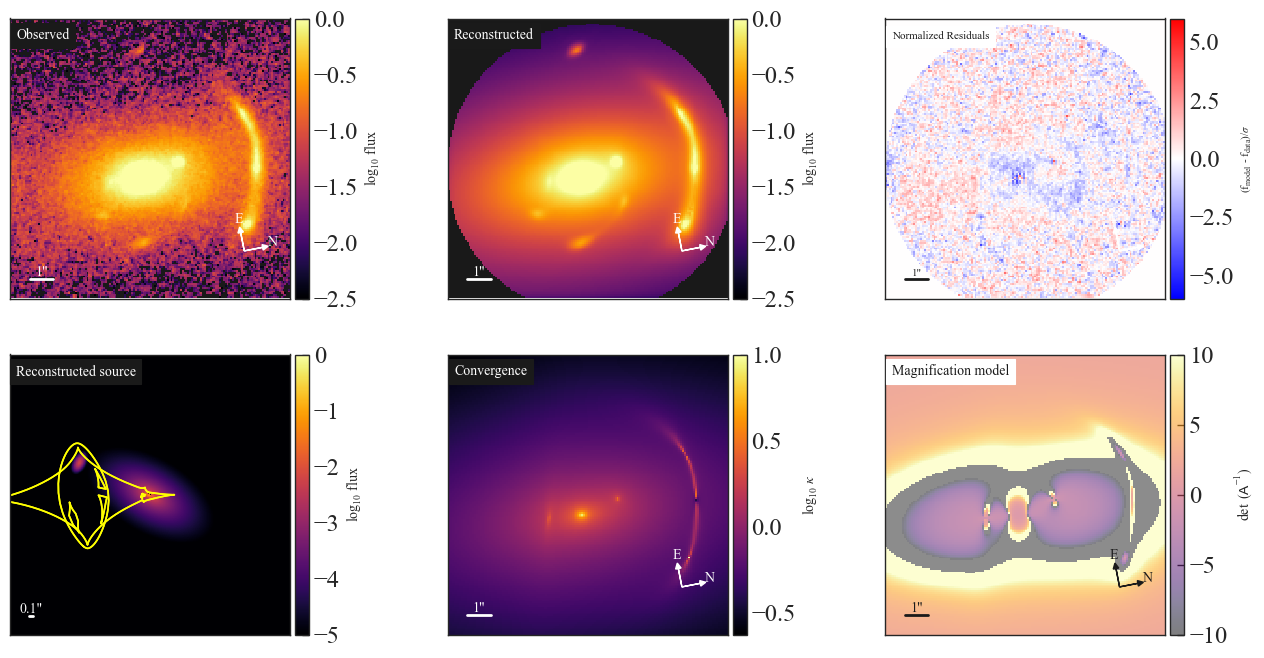

{'kwargs_lens': [{'Rs': 12.507443103792614, 'alpha_Rs': 4.369647734154799, 'e1': -0.353158712261353, 'e2': -0.039061791222105235, 'center_x': -0.8013036555732609, 'center_y': -0.4815451795362404}, {'gamma_ext': 0.04832827298117934, 'psi_ext': 1.0554497577704065, 'ra_0': 0, 'dec_0': 0}, {'theta_E': 0.14039387902490613, 'center_x': -0.41180443789762194, 'center_y': 1.1549751724633068}, {'theta_E': 0.1418840086476258, 'gamma': 2, 'e1': -0.035903828947067444, 'e2': -0.3026991086383282, 'center_x': -1.0649673519534115, 'center_y': 1.3708431154718055}, {'alpha_1': 0.42092639153409306, 'ratio': 0.9898756545476914, 'w_c1': 0.07606501251917679, 'w_t1': 0.3503546630055888, 'e11': -0.03828606850996896, 'e21': -0.016414123702239398, 'w_c2': 0.3444015424969858, 'w_t2': 2.963442854859148, 'e12': -0.3616256326985836, 'e22': -0.01718547191000611, 'center_x': -0.8013036555732609, 'center_y': -0.4815451795362404}, {'theta_E': 0.13434402095695855, 'e1': 0.47984786399815155, 'e2': 0.315704701955813, 'cent

In [34]:
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Plots import chain_plot


modelPlot = ModelPlot(multi_band_list_out, kwargs_model, kwargs_result, 
                      arrow_size=0.02, cmap_string="inferno", #inferno gist_heat
                      image_likelihood_mask_list=kwargs_likelihood['image_likelihood_mask_list']
                      )
#image_likelihood_mask_list=kwargs_likelihood['image_likelihood_mask_list'],
#multi_band_type='multi-linear',linear_solver = True

#param_class = fitting_seq.param_class
#print(param_class.num_param())
#print(chain_list)

#for i in range(len(chain_list)):
#    chain_plot.plot_chain_list(chain_list, i)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.data_plot(ax=axes[0,0],font_size=10,v_min=-2.5,v_max= 0 )#v_max= 2, v_min=-8 
modelPlot.model_plot(ax=axes[0,1],font_size=10, v_min=-2.5,v_max= 0 )#v_max= 2, v_min=-8
modelPlot.normalized_residual_plot(ax=axes[0,2],font_size=8, v_min=-6, v_max=6)
#modelPlot.absolute_residual_plot(ax=axes[0,2],font_size=8, v_min=-0.3, v_max=0.3)
modelPlot.source_plot(ax=axes[1, 0],font_size=10, deltaPix_source=0.01, numPix=720, with_caustics=True,v_max= 0, v_min=-5) #fast_caustic=True,
modelPlot.convergence_plot(ax=axes[1, 1],font_size=10,  v_max=1)
modelPlot.magnification_plot(ax=axes[1, 2],font_size=10)
#f.tight_layout()
#f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
#plt.show()

#f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

#modelPlot.decomposition_plot(ax=axes[0,0], text='Lens light', lens_light_add=True, unconvolved=True)
#modelPlot.decomposition_plot(ax=axes[1,0], text='Lens light convolved', lens_light_add=True)
#modelPlot.decomposition_plot(ax=axes[0,1], text='Source light', source_add=True, unconvolved=True)
#modelPlot.decomposition_plot(ax=axes[1,1], text='Source light convolved', source_add=True)
#modelPlot.decomposition_plot(ax=axes[0,2], text='All components', source_add=True, lens_light_add=True, unconvolved=True)
#modelPlot.decomposition_plot(ax=axes[1,2], text='All components convolved', source_add=True, lens_light_add=True, point_source_add=True)
#f.tight_layout()
#f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)

plt.savefig(fname=job_name_out+'.pdf')
plt.show()
print(kwargs_result)

-0.7929167960294277 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.7929167960294273


/Users/nandinisahu/opt/anaconda3/envs/py3/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:67: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)


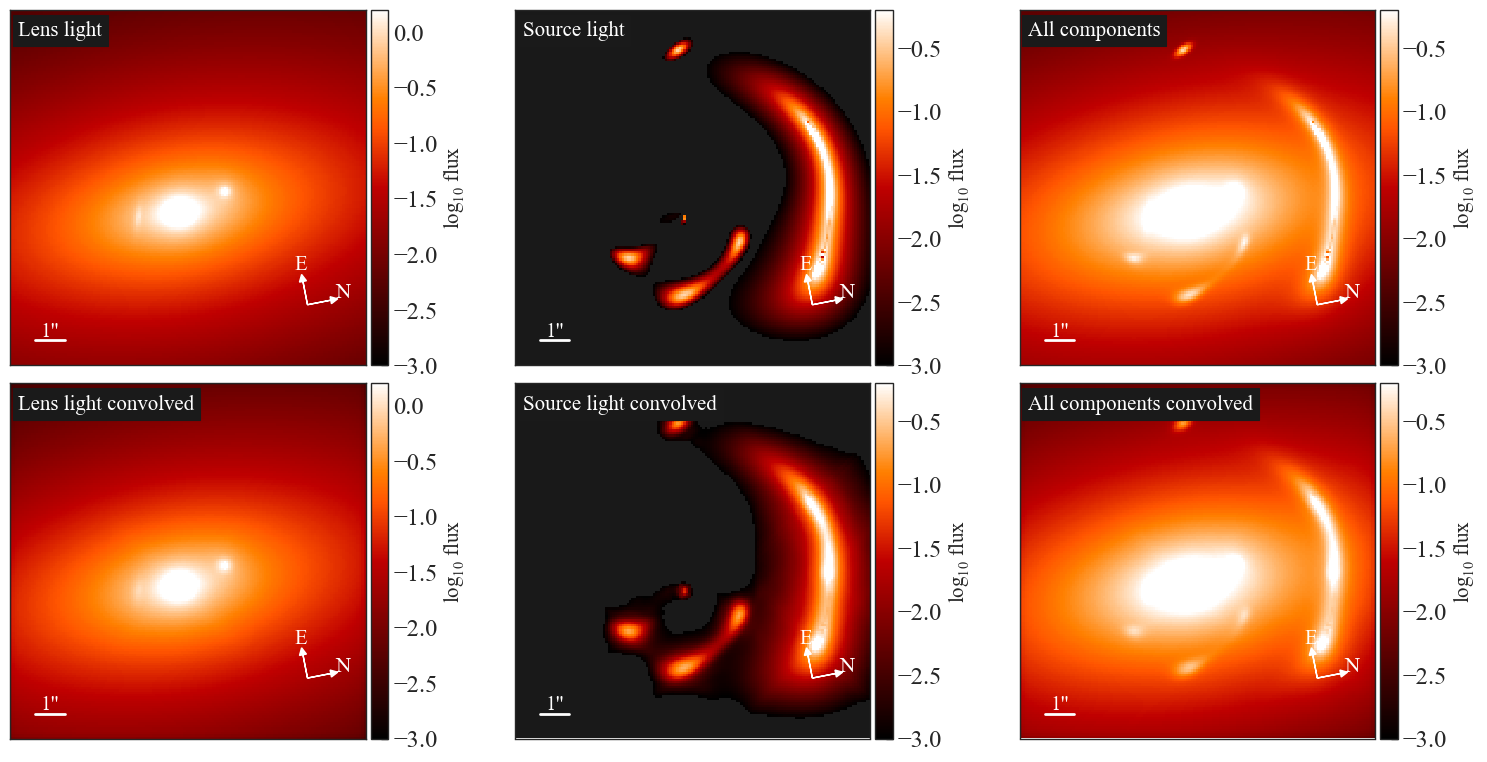

lens [{'Rs': 12.507443103792614, 'alpha_Rs': 4.369647734154799, 'e1': -0.353158712261353, 'e2': -0.039061791222105235, 'center_x': -0.8013036555732609, 'center_y': -0.4815451795362404}, {'gamma_ext': 0.04832827298117934, 'psi_ext': 1.0554497577704065, 'ra_0': 0, 'dec_0': 0}, {'theta_E': 0.14039387902490613, 'center_x': -0.41180443789762194, 'center_y': 1.1549751724633068}, {'theta_E': 0.1418840086476258, 'gamma': 2, 'e1': -0.035903828947067444, 'e2': -0.3026991086383282, 'center_x': -1.0649673519534115, 'center_y': 1.3708431154718055}, {'alpha_1': 0.42092639153409306, 'ratio': 0.9898756545476914, 'w_c1': 0.07606501251917679, 'w_t1': 0.3503546630055888, 'e11': -0.03828606850996896, 'e21': -0.016414123702239398, 'w_c2': 0.3444015424969858, 'w_t2': 2.963442854859148, 'e12': -0.3616256326985836, 'e22': -0.01718547191000611, 'center_x': -0.8013036555732609, 'center_y': -0.4815451795362404}, {'theta_E': 0.13434402095695855, 'e1': 0.47984786399815155, 'e2': 0.315704701955813, 'center_x': -0.6

In [35]:
# band index to plot the model breakdown, 0: F140W, 1: F200LP
band_i = 0

lensPlot = ModelPlot(multi_band_list_out, kwargs_model, kwargs_result, 
                     arrow_size=0.02, cmap_string="gist_heat",
                    image_likelihood_mask_list=kwargs_likelihood['image_likelihood_mask_list'], #kwargs_likelihood['image_likelihood_mask_list'],
                    multi_band_type='multi-linear', linear_solver = True
                    )
#if band_i == 0:
#    i = 'Observed: F140W'
#elif band_i ==1:
#    i = 'Observed: F200LP'

#i = 'Observed: F140W'

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

lensPlot.decomposition_plot(ax=axes[0,0], text='Lens light', lens_light_add=True, unconvolved=True, band_index=band_i, v_min=-3,v_max= 0.2) 
lensPlot.decomposition_plot(ax=axes[1,0], text='Lens light convolved', lens_light_add=True, band_index=band_i, v_min=-3,v_max= 0.2) 

lensPlot.decomposition_plot(ax=axes[0,1], text='Source light', source_add=True, unconvolved=True, band_index=band_i, v_min=-3,v_max= -0.2) 
lensPlot.decomposition_plot(ax=axes[1,1], text='Source light convolved', source_add=True, band_index=band_i, v_min=-3,v_max= -0.2) 

lensPlot.decomposition_plot(ax=axes[0,2], text='All components', source_add=True, lens_light_add=True, unconvolved=True, band_index=band_i, v_min=-3,v_max= -0.2) 
lensPlot.decomposition_plot(ax=axes[1,2], text='All components convolved', source_add=True, lens_light_add=True, point_source_add=True, band_index=band_i, v_min=-3,v_max= -0.2) 
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()

lens_result, source_result, lens_light_result, ps_result = kwargs_result['kwargs_lens'], kwargs_result['kwargs_source'], kwargs_result['kwargs_lens_light'], kwargs_result['kwargs_ps']
print('lens', lens_result, "\n\n source", source_result, '\n\n lens light', lens_light_result, '\n\n ps', ps_result)


In [36]:
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from astropy.cosmology import FlatLambdaCDM
lens_cosmo = LensCosmo(z_lens=0.594, z_source=2.591, cosmo=cosmo)
#units: rho0 [Msun/Mpc^3], Rs [Mpc], c, r200 [Mpc], M200 [Msun]
#c = r200/r
rho0, Rs, c, r200, M200 = lens_cosmo.nfw_angle2physical(Rs_angle=kwargs_result['kwargs_lens'][0]['Rs'], alpha_Rs=kwargs_result['kwargs_lens'][0]['alpha_Rs'])

In [37]:
print('Rs:', Rs*1000,'kpc')
print('r200:',r200*1000,'kpc')
print('Log M200:', np.log10(M200),'dex')
print('c200:',c)

Rs: 83.22803261418657 kpc
r200: 656.2639178162393 kpc
Log M200: 13.790045648755397 dex
c200: 7.885130733035931


In [38]:
from colossus.halo import concentration
from colossus.cosmology import cosmology

my_cosmo = {
        "flat": True,
        "H0": 70.0,
        "Om0": 0.3,
        "Ob0": 0.05,
        "sigma8": 0.823, #represents the root-mean-square fluctuation of matter density at a scale of 8/h Mpc in the universe today h=H0/100
        "ns": 0.96, #slope of the power spectrum of primordial density fluctuations
    }  # fiducial cosmo

cosmo1 = cosmology.setCosmology("my_cosmo", my_cosmo)

c200_rln = concentration.concentration(
        M200 * cosmo1.h,  #  input halo mass needs to be in M_sun/h unit
        "200c",
        0.594,
        model="diemer19"
    )
print(c200_rln)

4.049565899984198


### Plot result model centres

/var/folders/v5/068qyr6n1v16l5m5qs3sthxm0000gn/T/ipykernel_1430/1439745705.py:3: RuntimeWarning: invalid value encountered in log10
  ax.matshow(np.log10(data_cutout), origin='lower', cmap=cmap, vmin=-3, vmax=1.)


94.36174034701683 65.20251705170654


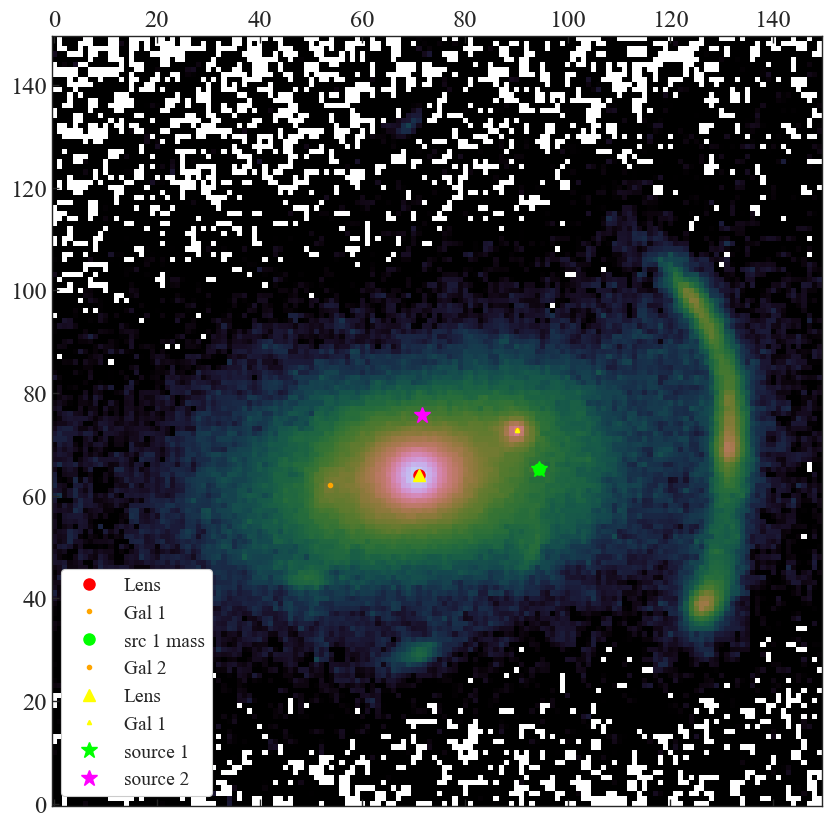

In [39]:

data_cutout = kwargs_data_F140W['image_data']
ax = plt.figure(figsize=(10, 10)).add_subplot(111)
ax.matshow(np.log10(data_cutout), origin='lower', cmap=cmap, vmin=-3, vmax=1.)
ax.autoscale(False)

#mass
lens_mass_x, lens_mass_y=coords.map_coord2pix(kwargs_result['kwargs_lens'][0]['center_x'],kwargs_result['kwargs_lens'][0]['center_y'] )
ax.plot(lens_mass_x, lens_mass_y, 'o', color='red',markersize=8, label='Lens') 
gal1_mass_x, gal1_mass_y=coords.map_coord2pix(kwargs_result['kwargs_lens'][2]['center_x'],kwargs_result['kwargs_lens'][2]['center_y'])
ax.plot(gal1_mass_x, gal1_mass_y, 'o', color='orange',markersize=3, label='Gal 1') 
src1_mass_x, src1_mass_y=coords.map_coord2pix(kwargs_result['kwargs_lens'][3]['center_x'],kwargs_result['kwargs_lens'][3]['center_y'] )
ax.plot(src1_mass_x, src1_mass_y, 'o', color='lime',markersize=8, label='src 1 mass') 
gal2_mass_x, gal2_mass_y=coords.map_coord2pix(kwargs_result['kwargs_lens'][5]['center_x'],kwargs_result['kwargs_lens'][5]['center_y'])
ax.plot(gal2_mass_x, gal2_mass_y, 'o', color='orange',markersize=3, label='Gal 2') 


#light
lens_light_x,lens_light_y=coords.map_coord2pix(kwargs_result['kwargs_lens_light'][0]['center_x'],kwargs_result['kwargs_lens_light'][0]['center_y'])
gal1_light_x,gal1_light_y=coords.map_coord2pix(kwargs_result['kwargs_lens_light'][1]['center_x'],kwargs_result['kwargs_lens_light'][1]['center_y'])
ax.plot(lens_light_x,lens_light_y, '^', color='yellow',markersize=8, label='Lens') 
ax.plot(gal1_light_x,gal1_light_y, '^', color='yellow',markersize=3, label='Gal 1')

#source
src1_x,src1_y=coords.map_coord2pix(kwargs_result['kwargs_source'][0]['center_x'],kwargs_result['kwargs_source'][0]['center_y'])
src2_x,src2_y=coords.map_coord2pix(kwargs_result['kwargs_source'][2]['center_x'],kwargs_result['kwargs_source'][2]['center_y'])

ax.plot(src1_x,src1_y, '*', color='lime', markersize=12, label='source 1')
ax.plot(src2_x,src2_y, '*', color='magenta',markersize=12,label='source 2')
print(src1_x,src1_y)

plt.legend(loc=3,fontsize=14, framealpha=1)
plt.show()

In [40]:
fit_output[0][1][1][-1]

-1.8955327891070843

In [41]:
parameter_names=fit_output[0][2]
likelihood_list=fit_output[0][1][0]
parameter_value_list=fit_output[2][1][1]
parameter_uncer_list=fit_output[2][1][2]
final_para={}
for i in range(len(parameter_names)):
    final_para['%s'%parameter_names[i]]=(parameter_value_list[-1][i], parameter_uncer_list[-1][i])
    
final_para

IndexError: list index out of range

/var/folders/v5/068qyr6n1v16l5m5qs3sthxm0000gn/T/ipykernel_1430/3931476946.py:15: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if not samples_mcmc == []:


N_step: 2000, N_walkers: 296, N_params: 37
Rs_lens0 12.4888 ± 0.2053
alpha_Rs_lens0 4.3854 ± 0.1057
e1_lens0 -0.3439 ± 0.1398
e2_lens0 -0.0399 ± 0.0845
gamma_ext_lens1 0.0469 ± 0.0455
psi_ext_lens1 1.0439 ± 0.0537
theta_E_lens2 0.1636 ± 0.0513
theta_E_lens3 0.1509 ± 0.0631
alpha_1_lens4 0.3597 ± 0.1136
theta_E_lens5 0.1328 ± 0.0371
R_sersic_source_light0 0.2128 ± 0.0678
n_sersic_source_light0 2.1814 ± 0.2835
e1_source_light0 -0.0419 ± 0.0751
e2_source_light0 -0.2978 ± 0.0698
center_x_source_light0 -1.0586 ± 0.0487
center_y_source_light0 1.3614 ± 0.0411
beta_source_light1 0.0187 ± 0.0008
center_x_source_light1 -1.0388 ± 0.0389
center_y_source_light1 1.3341 ± 0.0393
R_sersic_source_light2 0.0750 ± 0.0666
n_sersic_source_light2 0.6882 ± 0.1823
e1_source_light2 0.0274 ± 0.0929
e2_source_light2 0.2716 ± 0.0835
center_x_source_light2 0.0928 ± 0.0493
center_y_source_light2 -0.2547 ± 0.0627
center_x_lens_light0 -0.8008 ± 0.0315
center_y_lens_light0 -0.4810 ± 0.0318
R_sersic_lens_light1 0.3490 

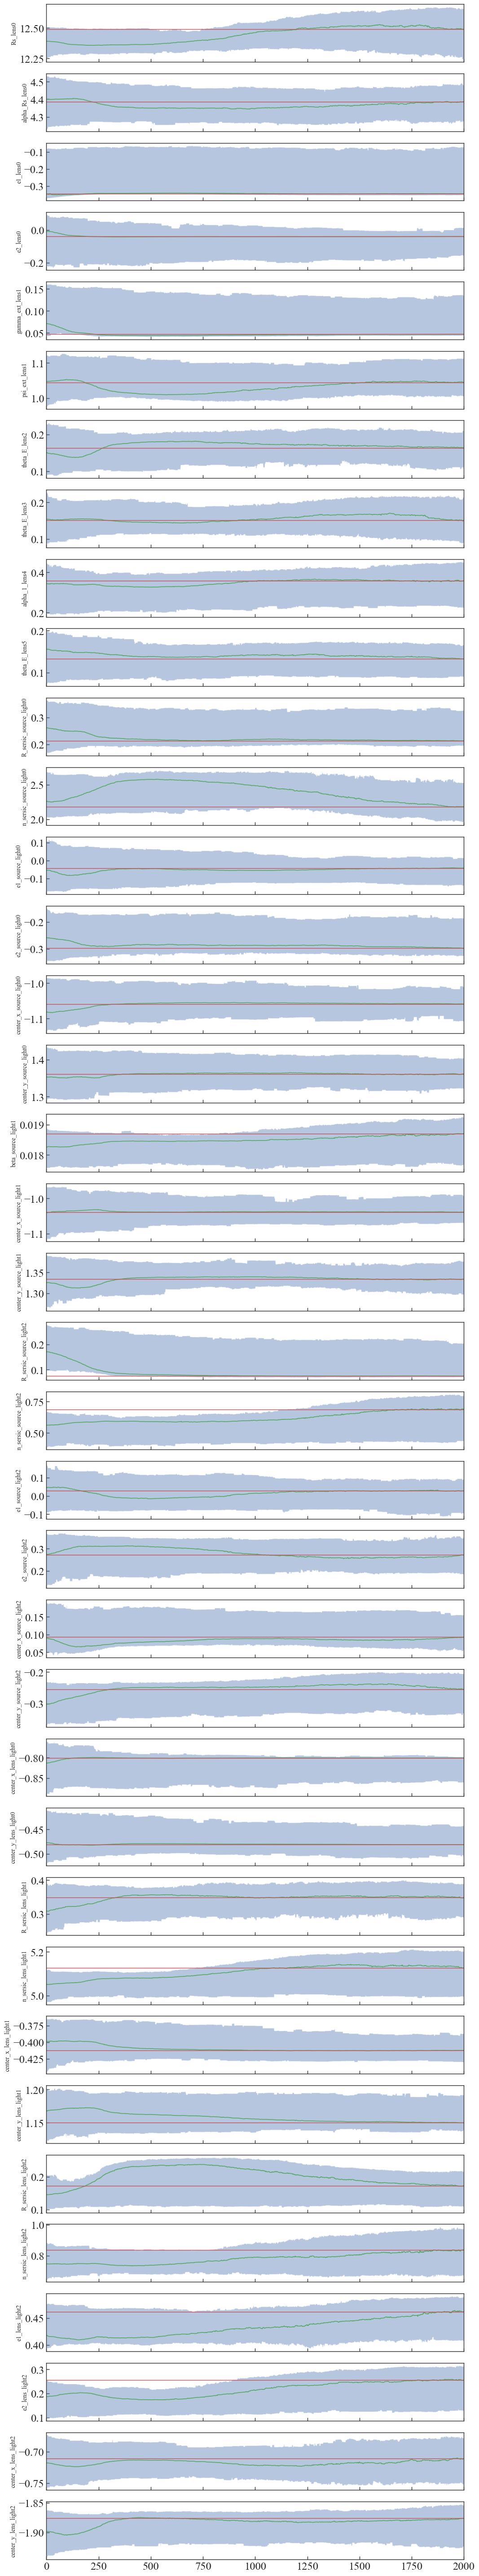

In [42]:
samples_mcmc = []

if fit_output[-1][0] != 'PSO':
    # if MCMC chain was broken in the chunks, we join the chunks to make the full chain
    mcmc_repeat = 1
      
    for k in range(len(fit_output)-mcmc_repeat, len(fit_output)):
        if samples_mcmc == []:
            samples_mcmc = fit_output[k][1]
        else:
            samples_mcmc = np.vstack((samples_mcmc, fit_output[k][1]))

        param_mcmc = fit_output[k][2]
    
if not samples_mcmc == []:
    n_params = samples_mcmc.shape[1]

    n_walkers = 8 * n_params
    n_step = int(samples_mcmc.shape[0] / n_walkers)

    print('N_step: {}, N_walkers: {}, N_params: {}'.format(n_step, n_walkers, n_params))

    chain = np.empty((n_walkers, n_step, n_params))

    for i in np.arange(n_params):
        samples = samples_mcmc[:, i].T
        chain[:,:,i] = samples.reshape((n_step, n_walkers)).T

    mean_pos = np.zeros((n_params, n_step))
    median_pos = np.zeros((n_params, n_step))
    std_pos = np.zeros((n_params, n_step))
    q16_pos = np.zeros((n_params, n_step))
    q84_pos = np.zeros((n_params, n_step))

    for i in np.arange(n_params):
        for j in np.arange(n_step):
            mean_pos[i][j] = np.mean(chain[:, j, i])
            median_pos[i][j] = np.median(chain[:, j, i])
            std_pos[i][j] = np.std(chain[:, j, i])
            q16_pos[i][j] = np.percentile(chain[:, j, i], 16.)
            q84_pos[i][j] = np.percentile(chain[:, j, i], 84.)

    fig, ax = plt.subplots(n_params, sharex=True, figsize=(8, 6))

    burnin = -1
    last = n_step

    medians = []

    param_values = [median_pos[0][last-1], (q84_pos[0][last-1]-q16_pos[0][last-1])/2,
                    median_pos[1][last-1], (q84_pos[1][last-1]-q16_pos[1][last-1])/2]

    for i in range(n_params):
        print(param_mcmc[i], '{:.4f} ± {:.4f}'.format(median_pos[i][last-1], (q84_pos[i][last-1]-q16_pos[i][last-1])/2))

        ax[i].plot(median_pos[i][:last], c='g')
        ax[i].axhline(np.median(median_pos[i][burnin:last]), c='r', lw=1)
        ax[i].fill_between(np.arange(last), q84_pos[i][:last], q16_pos[i][:last], alpha=0.4)
        ax[i].set_ylabel(param_mcmc[i], fontsize=10)
        ax[i].set_xlim(0, last)

        medians.append(np.median(median_pos[i][burnin:last]))

    if True:
        fig.set_size_inches((12., 2*len(param_mcmc)))
        plt.show()

In [43]:
sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = fit_output[0]
    
print("number of non-linear parameters in the MCMC process: ", len(param_mcmc))
print("parameters in order: ", param_mcmc)
print("number of evaluations in the MCMC process: ", np.shape(samples_mcmc)[0])
import corner

n, num_param = np.shape(samples_mcmc)
#plot = corner.corner(samples_mcmc[:,:8], labels=param_mcmc[:8], show_titles=True)

number of non-linear parameters in the MCMC process:  37
parameters in order:  ['Rs_lens0', 'alpha_Rs_lens0', 'e1_lens0', 'e2_lens0', 'gamma_ext_lens1', 'psi_ext_lens1', 'theta_E_lens2', 'theta_E_lens3', 'alpha_1_lens4', 'theta_E_lens5', 'R_sersic_source_light0', 'n_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'beta_source_light1', 'center_x_source_light1', 'center_y_source_light1', 'R_sersic_source_light2', 'n_sersic_source_light2', 'e1_source_light2', 'e2_source_light2', 'center_x_source_light2', 'center_y_source_light2', 'center_x_lens_light0', 'center_y_lens_light0', 'R_sersic_lens_light1', 'n_sersic_lens_light1', 'center_x_lens_light1', 'center_y_lens_light1', 'R_sersic_lens_light2', 'n_sersic_lens_light2', 'e1_lens_light2', 'e2_lens_light2', 'center_x_lens_light2', 'center_y_lens_light2']
number of evaluations in the MCMC process:  592000


In [44]:
38*2000*8

608000

In [ ]:
import numpy as np
import corner

# Your MCMC sample
sample = samples_mcmc[400000:, :9]  # Last part of the sample, excluding burn-in
col_name = param_mcmc[:9]           # Parameter names

# Calculate the median for each parameter
medians = np.median(sample, axis=0)

# Set a fixed range around the median for each parameter (e.g., +/- 3 standard deviations or other range)
range_width = 3  # Adjust this value as needed for the width around the median
ranges = [
    (medians[i] - range_width * np.std(sample[:, i]), medians[i] + range_width * np.std(sample[:, i]))
    for i in range(sample.shape[1])
]

# Create the corner plot with the customized ranges
figure = corner.corner(
    sample,
    color='green',
    labels=col_name,
    title_quantiles=[0.16, 0.5, 0.84],
    title_fmt=".3f",
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    smooth=1,  # Adjust smoothing as needed
    #bins=20,
    range=ranges,  # Use custom ranges centered around the medians
    #plot_density=True,
    levels=[0.68, 0.95], #
    contour_kwargs={"colors": "orange"},
    hist_kwargs={"color": "blue"},  # Set color of the histograms
    hist_bin_factor=1
)


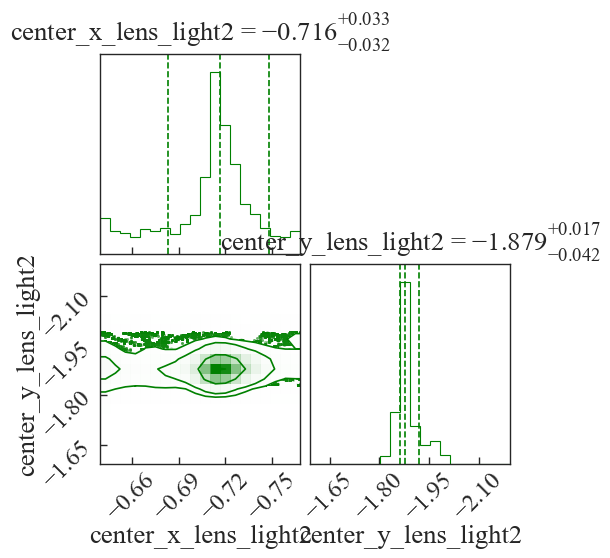

In [50]:
sample=samples_mcmc[100000:,35:37] #discarding first 50,000 line 1st index mcmc lines and 2nd parameters
col_name=param_mcmc[35:37]
# Automatically determine the range for each parameter based on percentiles
percentile_bounds = [(np.percentile(sample[:, i], 0)*0.8, np.percentile(sample[:, i], 100)*1.2) for i in range(sample.shape[1])]

figure = corner.corner(sample,color='green',
                       labels=col_name,
                       title_quantiles=[0.16, 0.5, 0.84],
                       title_fmt=".3f",
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True,
                       smooth=1,
                       range=percentile_bounds #[(9, 11), (3.6, 5)] #limits_94[40:42] #
                       )

Removed no burn in


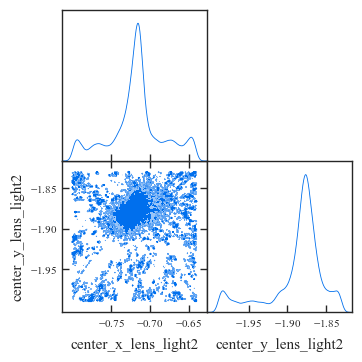

In [51]:
import getdist
from getdist import plots, MCSamples

# Triangle plot using GetDist
param_names = param_mcmc[35:37]
samples = samples_mcmc[100000:, 35:37]
gdsamples = MCSamples(samples=samples, names=param_names,labels=None) #, labels=[r"$w$", r"$\Omega_m$"] ,labels=['w', 'Omega_m']
#percentile_bounds = [(np.percentile(samples[:, i], 1)*1.5, np.percentile(samples[:, i], 99)*0.5) for i in range(samples.shape[1])]

range_limits = {
    param_names[i]: (
        np.percentile(samples[:, i], 1) * 0.9,  # 0th percentile scaled by 0.9
        np.percentile(samples[:, i], 99) * 1.1  # 100th percentile scaled by 1.1
    )
    for i in range(samples.shape[1])
}


g = plots.get_subplot_plotter()
fig = plt.figure(figsize=(15, 15))
#range_limits = {'w': [-2.0, 0], 'omega_m': [0., 1]}  # Modify these ranges as needed

g.triangle_plot([gdsamples], filled=True, 
                #markers={'w': median_value_w0, 'omega_m': median_value_omega_m},
                contour_args={'alpha': 1.0},
                limits=range_limits
               )  # Apply range limits here

plt.close(fig)

In [38]:
1/a_1_fiducial

0.9432781030302345

In [45]:
factor_a_1_limit=1/(a_1_fiducial*0.9405)
print(factor_a_1_limit)

1.0029538575547416


In [46]:
factor_a_1_limit1=1/(a_1_fiducial*0.946)
print(factor_a_1_limit1)

0.997122730475935


In [47]:
1.0029538575547416-1

0.0029538575547416457

In [48]:
1-0.997122730475935

0.0028772695240649737